Import needed modules

In [1]:
# import system libs 
import os
import time
import shutil
import itertools
import pathlib

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# import data handling tools 
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import categorical_crossentropy

print ('modules loaded')

modules loaded


# Create needed functions

#### Function to Create Data Frame from Dataset

In [2]:
# Generate data paths with lables 
def define_paths(dir):
    filepaths = []
    labels = []
        
    folds = os.listdir(dir)
    for fold in folds:
        foldpath = os.path.join(dir, fold)
        if pathlib.Path(foldpath).suffix != '':
            continue
        
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Conctainate data pathes with lables into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)


# Split data into train, validation, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.7, shuffle= True, random_state= 123, stratify= strat)
    
    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)
    return train_df, valid_df, test_df    

#### Function to generate images from dataframe

In [3]:
def create_model_data (train_df, valid_df, test_df, batch_size):
    
    ''' This function takes train, validation, and test dataframe and fit them into image data generator, because model takes 
         data from image data generator. 
         Image data generator converts images into tensors. '''
    

    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)
    
    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size
    
    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img
    
    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)
    
    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)
    
    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size) 
    
    
    return train_gen, valid_gen, test_gen

### **Function to reduce the huge amount of data**

In [4]:
def trim (df, max_size, min_size, column):
    df = df.copy()
    original_class_count = len(list(df[column].unique()))
    print ('Original Number of classes in dataframe: ', original_class_count)
    
    sample_list = [] 
    groups = df.groupby(column)
    
    for label in df[column].unique():        
        group = groups.get_group(label)
        sample_count = len(group)     
        if sample_count > max_size :
            strat = group[column]
            samples, _ = train_test_split(group, train_size= max_size, shuffle= True, 
                                          random_state= 123, stratify= strat)            
            sample_list.append(samples)
      
        elif sample_count >= min_size:
            sample_list.append(group)
    
    df = pd.concat(sample_list, axis= 0).reset_index(drop= True)
    final_class_count = len(list(df[column].unique())) 
    if final_class_count != original_class_count:
        print ('*** WARNING***  dataframe has a reduced number of classes' )
    balance = list(df[column].value_counts())
    print (balance)
    return df

#### Function to display data sample

In [5]:
def show_images(gen):
    
    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index} 
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string 
    images, labels = next(gen)        # get a batch size samples from the generator
    
    
    # calculate number of dispalyed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images
    
    plt.figure(figsize= (20, 20))
    
    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        
        # note 
        index = np.argmax(labels[i])  # get image index
        
        class_name = classes[index]   # get class of image
        
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Callbacks** 
<br> 
Callbacks : Helpful functions to help optimize model training  <br> 
Examples: stop model training after specfic time, stop training if no improve in accuracy and so on.

In [6]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans == 'Y' or ans == 'y':
            self.ask_permission = 1
        elif ans == 'N' or ans == 'n':
            self.ask_permission = 0
        
        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights) 


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100 
        loss = logs.get('loss')
        
        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '') 


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss
            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                else:
                    self.count = self.count + 1 # increment the patience counter
                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)
                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch ' + str(self.ask_epoch)
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)
                        except:
                            print('Invalid')

#### Function to plot history of training

In [7]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout
    plt.show()


#### Function to create Confusion Matrix

In [8]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# Model Structure

#### Start Reading Dataset

Original Number of classes in dataframe:  5
[3000, 3000, 3000, 3000, 3000]
Original Number of classes in dataframe:  5
[700, 700, 700, 700, 700]
Original Number of classes in dataframe:  5
[700, 700, 700, 700, 700]
Found 15000 validated image filenames belonging to 5 classes.
Found 3500 validated image filenames belonging to 5 classes.
Found 3500 validated image filenames belonging to 5 classes.


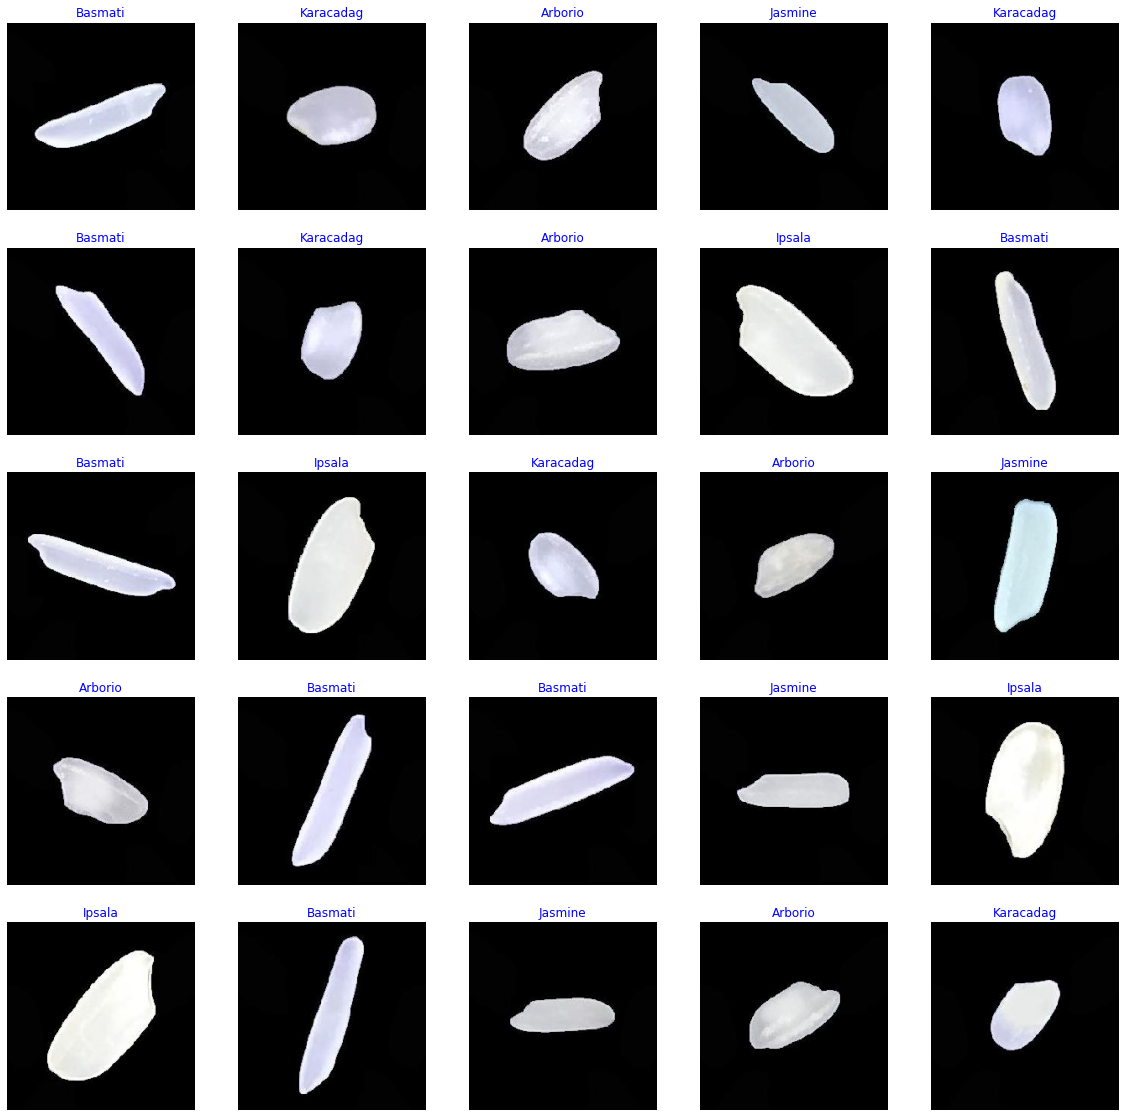

In [9]:
# Get Dataframes
data_dir = '/kaggle/input/rice-image-dataset/Rice_Image_Dataset'
train_df, valid_df, test_df = split_data(data_dir)

# Reduce data volume
train_df = trim(train_df, max_size = 3000, min_size = 0, column='labels')
valid_df = trim(train_df, max_size = 700, min_size = 0, column='labels')
test_df = trim(train_df, max_size = 700, min_size = 0, column='labels')

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_model_data(train_df, valid_df, test_df, batch_size)

# Display Image Samples
show_images(train_gen)

#### Generic Model Creation

In [10]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer      

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
base_model = tf.keras.applications.xception.Xception(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

2023-01-28 22:14:28.362114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 22:14:28.371108: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 22:14:28.371850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-28 22:14:28.372899: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
batch_normalization_4 (Batch (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 1285      
Total params: 21,395,501
Trainable params: 21,336,877
Non-trainable params: 58,624
_________________________________________________________________


#### Set Callback Parameters

In [11]:
batch_size = 40     # set batch size for training
epochs = 40         # number of all epochs in training
patience = 1 		    # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 	# number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9 	  # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = 0.5 		    # factor to reduce lr by
ask_epoch = 5		    # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience,
            stop_patience= stop_patience, threshold= threshold, factor= factor,
            batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

#### Train model

In [12]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?


 y


 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration


2023-01-28 22:14:33.513664: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-28 22:14:38.201512: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


 1 /40     4.009   97.780   1.71811  99.800   0.00100  0.00100  val_loss     0.00    195.14 
 2 /40     0.983   99.473   0.47898  99.800   0.00100  0.00100  val_loss    72.12    187.92 
 3 /40     0.333   99.547   0.19521  99.886   0.00100  0.00100  val_loss    59.25    187.82 
 4 /40     0.187   99.620   0.13528  99.971   0.00100  0.00100  val_loss    30.70    187.87 
 5 /40     0.152   99.573   0.11545  99.857   0.00100  0.00100  val_loss    14.66    187.64 
enter H to halt training or an integer for number of epochs to run then ask again


 5


 training will continue until epoch 10
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 6 /40     0.131   99.707   0.10426  100.000  0.00100  0.00100  val_loss     9.69    187.47 
 7 /40     0.119   99.787   0.09601  100.000  0.00100  0.00100  val_loss     7.92    187.27 
 8 /40     0.113   99.753   0.08878  100.000  0.00100  0.00100  val_loss     7.53    187.27 
 9 /40     0.099   99.853   0.08625  99.886   0.00100  0.00100  val_loss     2.85    187.21 
10 /40     0.097   99.740   0.07667  99.943   0.00100  0.00100  val_loss    11.10    187.31 
enter H to halt training or an integer for number of epochs to run then ask again


 h


training has been halted at epoch 10 due to user input
training elapsed time was 0.0 hours, 32.0 minutes, 14.06 seconds)


#### Display model performance

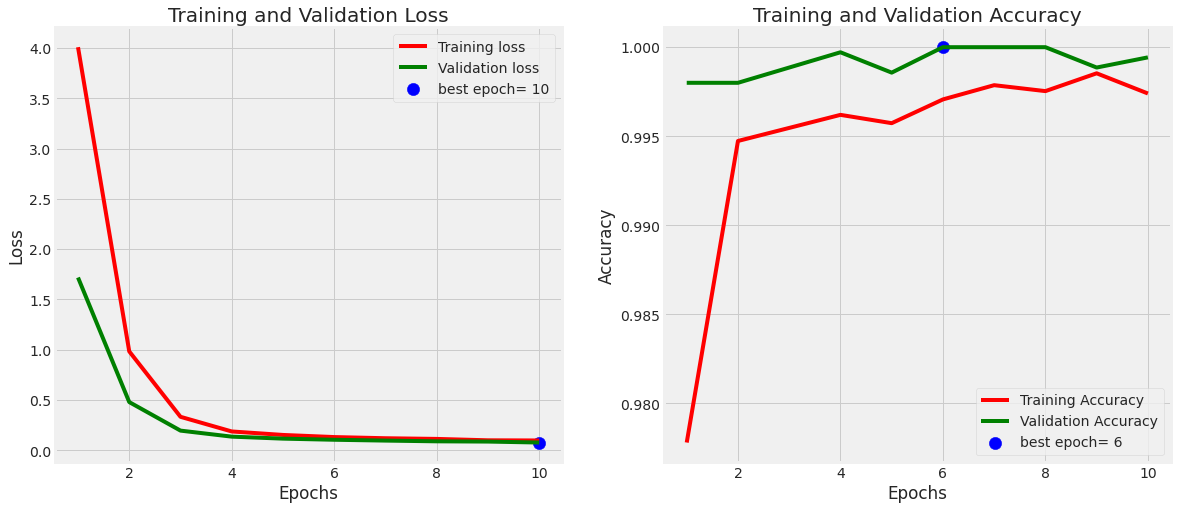

In [13]:
plot_training(history)

### Evaluate model

In [14]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

50/50 [==============================] - 12s 232ms/step - loss: 0.0767 - accuracy: 0.9994
Train Loss:  0.07609985768795013
Train Accuracy:  1.0
--------------------
Validation Loss:  0.07752618938684464
Validation Accuracy:  0.9990000128746033
--------------------
Test Loss:  0.07667423039674759
Test Accuracy:  0.9994285702705383


### Get Predictions

In [15]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[0 0 0 ... 1 1 1]


#### Confusion Matrics and Classification Report

Confusion Matrix, Without Normalization
[[700   0   0   0   0]
 [  0 700   0   0   0]
 [  0   0 700   0   0]
 [  2   0   0 698   0]
 [  0   0   0   0 700]]
              precision    recall  f1-score   support

     Arborio       1.00      1.00      1.00       700
     Basmati       1.00      1.00      1.00       700
      Ipsala       1.00      1.00      1.00       700
     Jasmine       1.00      1.00      1.00       700
   Karacadag       1.00      1.00      1.00       700

    accuracy                           1.00      3500
   macro avg       1.00      1.00      1.00      3500
weighted avg       1.00      1.00      1.00      3500



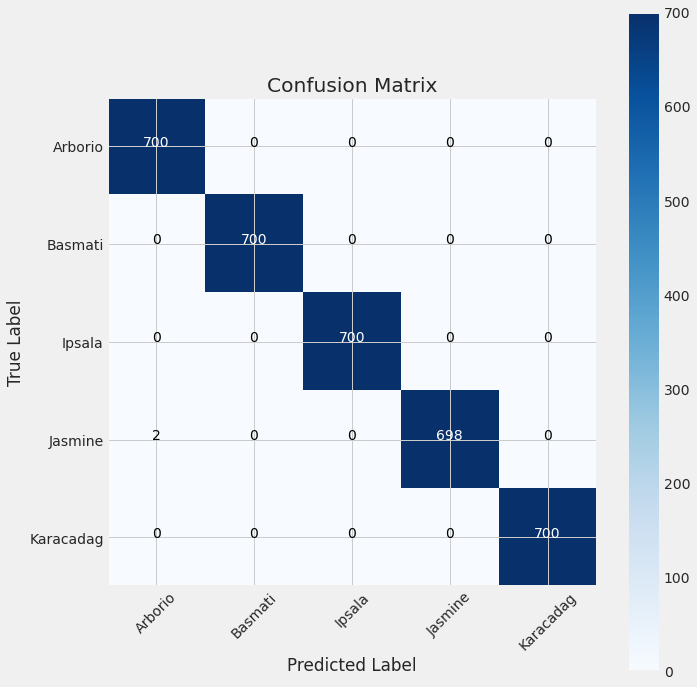

In [16]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

### Save model

In [17]:
model_name = model.input_names[0][:-6]
subject = input('Enter Project Subject')
acc = test_score[1] * 100
save_path = ''

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}-weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

Enter Project Subject Rice Classification


model was saved as xception-Rice Classification-99.94.h5
weights were saved as xception-Rice Classification-weights.h5


### Generate CSV files containing classes indicies & image size 

In [18]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')

class csv file was saved as Rice Classification-class_dict.csv
